# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [2]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection
from scipy.stats import randint as sp_randint

/home/pato/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

display(X)
display(y)


# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


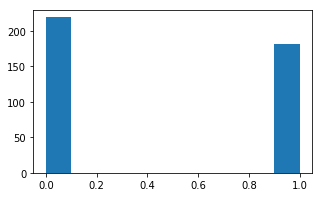

In [10]:
# EJERCICIO 1. 


########################################################
np.random.seed(1234)
X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size = 1/5)

# X_eval y_eval: son el heldout, separados usando la misma proporcion de malos y buenos, y shuffleando. DEF 

#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

### Splitting

Se decidio utilizar un 20% de los datos como conjunto de Held-Out. Esta Permanecera incorrupta hasta el final del experimento.


## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

In [34]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados

# Hacer arbol
# (Separar en KFold)
# Iterar por cada fold: fitear arbol, calcular accuracies y aucs en training y validation y guardarlos

arbol = DecisionTreeClassifier(max_depth=3)
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
scores = sklearn.model_selection.cross_validate(arbol, X_dev_np, y_dev_np, cv = 5,
                                                scoring=['accuracy', 'roc_auc'], return_train_score=True)

#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = scores['train_accuracy']     # cambiar por accuracies_training
df["Accuracy (validación)"] = scores['test_accuracy']   # cambiar por accuracies_validation
df["AUC ROC (training)"] = scores['train_roc_auc']      # cambiar por aucs_training
df["AUC ROC (validación)"] = scores['test_roc_auc']    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
# df.plot(kind="bar")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8150,0.5926,0.8836,0.5845
2,0.8500,0.6250,0.8832,0.6427
3,0.8063,0.6625,0.8831,0.6989
4,0.8344,0.7250,0.8639,0.7418
5,0.8037,0.5949,0.8656,0.5795


In [35]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
# np.random.seed(SEED)
# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         CODIGO AQUI.
#         resultados_training.append( <RESULTADO_TRAINING> )
#         resultados_validation.append( <RESULTADO_VALIDATION> )
np.random.seed(1234)
for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
        scores = sklearn.model_selection.cross_validate(arbol, X_dev_np, y_dev_np, cv = 5, 
                                                        scoring=['roc_auc'], return_train_score=True)
        resultados_training.append( scores['train_roc_auc'].mean() )
        resultados_validation.append( scores['test_roc_auc'].mean() )

#########################################################


df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation


display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8759,0.6495
1,5,Gini,0.9744,0.5912
2,Inifinito,Gini,1.0000,0.6180
3,3,Ganancia de Información,0.8776,0.6845
4,5,Ganancia de Información,0.9794,0.6610
5,Inifinito,Ganancia de Información,1.0000,0.6365


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=10):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

########################################################
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

In [51]:
##### KNN PARAMETERS
# n_neighbors Number of neighbors
# p=1 Manhattan_distance
# p=2 Euclidean_distance (l2) 
# p=!1 y 2 Minkowski_distance(p)
# weights='uniform' All points in each neighborhood are weighted equally
# weights='distance' Weight points by the inverse of their distance
### como minkowski es la metrica default usando solo p puedo simular las otras mas usuales. 
### Los demas no los usamos porque son mas de eficiencia algoritmica que de aprendizaje.
knn_grid_parameters = {
    'n_neighbors': [1, 5, 10, 15, 20], 
    'weights': ['uniform', 'distance'],
    'p':[1,2,5]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
25,20,1,distance,0.8346,1.0000
26,20,2,uniform,0.8338,0.8735
27,20,2,distance,0.8338,1.0000
24,20,1,uniform,0.8330,0.8630
18,15,1,uniform,0.8303,0.8690
19,15,1,distance,0.8290,1.0000
21,15,2,distance,0.8278,1.0000
20,15,2,uniform,0.8267,0.8747
13,10,1,distance,0.8205,1.0000
12,10,1,uniform,0.8188,0.8799


In [71]:
##### KNN ITERATION 1
knn_grid_parameters = {
    'n_neighbors': [10, 50, 100, 150], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
9,100,1,distance,0.8454,1.0000
7,50,2,distance,0.8450,1.0000
11,100,2,distance,0.8446,1.0000
8,100,1,uniform,0.8445,0.8538
10,100,2,uniform,0.8436,0.8466
6,50,2,uniform,0.8434,0.8628
13,150,1,distance,0.8380,1.0000
15,150,2,distance,0.8366,1.0000
14,150,2,uniform,0.8360,0.8428
12,150,1,uniform,0.8359,0.8403


In [72]:
##### KNN ITERATION 2
knn_grid_parameters = {
    'n_neighbors': [50, 60, 70, 80, 90, 100], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
7,60,2,distance,0.8496,1.0000
13,80,1,distance,0.8482,1.0000
6,60,2,uniform,0.8478,0.8641
17,90,1,distance,0.8478,1.0000
12,80,1,uniform,0.8467,0.8582
19,90,2,distance,0.8462,1.0000
16,90,1,uniform,0.8462,0.8539
11,70,2,distance,0.8454,1.0000
21,100,1,distance,0.8454,1.0000
3,50,2,distance,0.8450,1.0000


In [74]:
##### KNN ITERATION 3
knn_grid_parameters = {
    'n_neighbors': [55, 57, 59, 60, 61, 63, 65], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
3,55,2,distance,0.8498,1.0000
15,60,2,distance,0.8496,1.0000
23,63,2,distance,0.8491,1.0000
19,61,2,distance,0.8481,1.0000
7,57,2,distance,0.8480,1.0000
11,59,2,distance,0.8480,1.0000
14,60,2,uniform,0.8478,0.8641
10,59,2,uniform,0.8473,0.8641
2,55,2,uniform,0.8472,0.8638
22,63,2,uniform,0.8471,0.8630


In [58]:
##### DT PARAMETERS
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth':[3, 4, 5, 7, 10, None],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)



Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
1,gini,3.0,sqrt,1,2,random,0.7714,0.7525
41,gini,3.0,None,1,10,random,0.7654,0.8309
4,gini,3.0,sqrt,1,10,best,0.7554,0.8286
623,entropy,NaN,log2,3,10,random,0.7534,0.9060
324,entropy,3.0,sqrt,1,2,best,0.7507,0.8375
425,entropy,4.0,None,3,10,random,0.7483,0.8888
408,entropy,4.0,log2,5,2,best,0.7480,0.8733
410,entropy,4.0,log2,5,6,best,0.7474,0.8738
358,entropy,3.0,log2,5,10,best,0.7459,0.8131
7,gini,3.0,sqrt,3,2,random,0.7442,0.7365


In [57]:
##### DT ITERATION 1
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth':[3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', 100, 75, 50]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)


Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
1107,gini,4,50,20,3,random,0.7742,0.8104
861,gini,4,100,10,15,random,0.7736,0.8508
1,gini,3,sqrt,1,2,random,0.7714,0.7525
2159,entropy,4,50,2,20,random,0.7704,0.8467
1000,gini,4,75,20,6,best,0.7697,0.8986
2001,entropy,4,100,20,2,random,0.7694,0.8316
875,gini,4,100,15,10,random,0.7686,0.8410
1708,entropy,4,sqrt,2,15,best,0.7682,0.8954
893,gini,4,100,20,15,random,0.7674,0.8144
2196,entropy,4,50,10,4,best,0.7674,0.9033


In [69]:
##### DT ITERATION 2
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['random'],
    'max_depth':[4],
    'min_samples_split': [2, 3, 7, 9, 12, 16, 18, 20, 25, 30],
    'min_samples_leaf': [1, 10, 12, 14, 16, 18, 20, 25, 30],
    'max_features': [100, 90, 80, 70, 60, 50]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
752,entropy,4,80,14,7,random,0.7833,0.8294
354,gini,4,70,30,12,random,0.7824,0.8026
755,entropy,4,80,14,16,random,0.7802,0.8241
687,entropy,4,90,18,20,random,0.7785,0.8380
329,gini,4,70,18,30,random,0.7784,0.8222
310,gini,4,70,16,2,random,0.7770,0.8212
964,entropy,4,60,20,12,random,0.7763,0.8090
439,gini,4,60,25,30,random,0.7750,0.7960
111,gini,4,90,12,3,random,0.7749,0.8434
625,entropy,4,100,30,16,random,0.7748,0.7956


In [70]:
##### DT ITERATION 3
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['random'],
    'max_depth':[4],
    'min_samples_split': [5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22],
    'min_samples_leaf': [13, 14, 15, 16, 17, 18, 19, 20],
    'max_features': [80, 70]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
32,gini,4,80,15,16,random,0.7840,0.8408
400,entropy,4,70,19,20,random,0.7836,0.8325
27,gini,4,80,15,6,random,0.7788,0.8301
56,gini,4,80,17,9,random,0.7778,0.8256
265,entropy,4,80,17,15,random,0.7755,0.8377
329,entropy,4,70,14,9,random,0.7734,0.8252
228,entropy,4,80,14,17,random,0.7724,0.8356
310,entropy,4,80,20,21,random,0.7714,0.8267
243,entropy,4,80,15,19,random,0.7690,0.8270
114,gini,4,70,13,20,random,0.7674,0.8248


In [87]:
##### LDA PARAMETERS
lda_grid_parameters = [{
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': ['auto', 0.1, 0.25, 0.50, 0.75, 0.9, 1.0]
}, {
    'solver': ['svd'], 
    'tol': [0.0, 0.1, 0.25, 0.50, 0.75, 0.9, 1.0]
}]
# svd no usa shrinkage, si  usa tol

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,shrinkage,solver,tol,mean_score_validation,mean_score_training
8,0.75,lsqr,NaN,0.8522,0.9480
9,0.75,eigen,NaN,0.8518,0.9481
11,0.9,eigen,NaN,0.8464,0.9076
10,0.9,lsqr,NaN,0.8460,0.9069
7,0.5,eigen,NaN,0.8407,0.9796
6,0.5,lsqr,NaN,0.8405,0.9796
1,auto,eigen,NaN,0.8318,0.9847
13,1,eigen,NaN,0.8312,0.8563
12,1,lsqr,NaN,0.8312,0.8563
0,auto,lsqr,NaN,0.8285,0.9856


In [88]:
##### LDA ITERATION 1
lda_grid_parameters = {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
}
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,shrinkage,solver,mean_score_validation,mean_score_training
4,0.70,lsqr,0.8539,0.9567
5,0.70,eigen,0.8536,0.9567
6,0.75,lsqr,0.8522,0.9480
7,0.75,eigen,0.8518,0.9481
2,0.65,lsqr,0.8517,0.9636
3,0.65,eigen,0.8516,0.9636
8,0.80,lsqr,0.8514,0.9373
9,0.80,eigen,0.8513,0.9377
0,0.60,lsqr,0.8498,0.9697
1,0.60,eigen,0.8495,0.9697


In [89]:
##### LDA ITERATION 2
lda_grid_parameters = {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': [0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75]
}
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,shrinkage,solver,mean_score_validation,mean_score_training
10,0.70,lsqr,0.8539,0.9567
9,0.69,eigen,0.8539,0.9582
13,0.71,eigen,0.8536,0.9552
12,0.71,lsqr,0.8536,0.9552
11,0.70,eigen,0.8536,0.9567
8,0.69,lsqr,0.8535,0.9581
14,0.72,lsqr,0.8532,0.9535
15,0.72,eigen,0.8529,0.9535
17,0.73,eigen,0.8529,0.9517
7,0.68,eigen,0.8529,0.9597


#### Conclusiones Grid Search

< < COMPLETAR > >

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
